## Import Dependencies



In [1]:
# import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
import tensorflow_ranking as tfr
import time
import os, os.path
import tensorflow as tf
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.models import Model
import random
import pandas as pd
from tensorflow.keras.preprocessing import image
import csv

/home/kevin20307/.local/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## Import Custom Dataset

Before upload, make sure that your data is in the structure

folder

---class1
    
------images
  
---class2

------images
  
  ...

In [2]:
train_dir = 'train_new_aug/train_new/train'
test_dir = 'test_new/test'

batch_size = 32

#define input height and width
width = 224
height = 224
input_shape = (height, width, 3)

In [3]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [4]:
train_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
    preprocessing_function = data_augment
)

val_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,
    rescale=1/255,
    validation_split=0.2)

test_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        directory = train_dir,
        target_size=(height, width),
        batch_size=batch_size,
        shuffle = True,
        subset='training'
        )

val_generator = val_datagen.flow_from_directory(
        # This is the target directory
        directory = train_dir,
        target_size=(height, width),
        batch_size=batch_size,
        shuffle = False,
        subset='validation'
        )
print(train_generator.class_indices)

Found 22920 images belonging to 49 classes.
Found 5706 images belonging to 49 classes.
{'三杯雞': 0, '什錦炒麵': 1, '咖哩雞': 2, '塔香海茸': 3, '大陸妹': 4, '客家小炒': 5, '小番茄': 6, '有機小松菜': 7, '有機青松菜': 8, '木瓜': 9, '柳丁': 10, '棗子': 11, '橘子': 12, '沙茶肉片': 13, '油菜': 14, '洋蔥炒蛋': 15, '滷蛋': 16, '滷雞腿': 17, '玉米炒蛋': 18, '瓜仔肉': 19, '番茄炒蛋': 20, '白米飯': 21, '白菜滷': 22, '空心菜': 23, '糖醋雞丁': 24, '紅蘿蔔炒蛋': 25, '義大利麵': 26, '芥藍菜': 27, '菠菜': 28, '葡萄': 29, '蒜泥白肉': 30, '蒸蛋': 31, '蓮霧': 32, '螞蟻上樹': 33, '西瓜': 34, '豆芽菜': 35, '關東煮': 36, '青江菜': 37, '香蕉': 38, '香酥魚排': 39, '馬鈴薯燉肉': 40, '高麗菜': 41, '鳳梨': 42, '鵝白菜': 43, '鹽酥雞': 44, '麥克雞塊': 45, '麻婆豆腐': 46, '麻油雞': 47, '黑胡椒豬柳': 48}


In [5]:
name_list=[]
class_list=[]
for item in train_generator.class_indices.items():
    name_list.append(item[0])
    class_list.append(item[1])
print(name_list)
print(class_list)

['三杯雞', '什錦炒麵', '咖哩雞', '塔香海茸', '大陸妹', '客家小炒', '小番茄', '有機小松菜', '有機青松菜', '木瓜', '柳丁', '棗子', '橘子', '沙茶肉片', '油菜', '洋蔥炒蛋', '滷蛋', '滷雞腿', '玉米炒蛋', '瓜仔肉', '番茄炒蛋', '白米飯', '白菜滷', '空心菜', '糖醋雞丁', '紅蘿蔔炒蛋', '義大利麵', '芥藍菜', '菠菜', '葡萄', '蒜泥白肉', '蒸蛋', '蓮霧', '螞蟻上樹', '西瓜', '豆芽菜', '關東煮', '青江菜', '香蕉', '香酥魚排', '馬鈴薯燉肉', '高麗菜', '鳳梨', '鵝白菜', '鹽酥雞', '麥克雞塊', '麻婆豆腐', '麻油雞', '黑胡椒豬柳']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


In [6]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(height, width),
        batch_size=batch_size,
        shuffle = False,
        class_mode=None,
        classes=name_list)

Found 7002 images belonging to 49 classes.


In [7]:
print(train_generator.class_indices == test_generator.class_indices)

True


In [8]:
ddf=pd.DataFrame()
ddf['Name']=name_list
ddf['Label']=class_list
ddf.to_csv('cat.csv',index=False)

In [9]:
ttt_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(height, width),
        batch_size=batch_size,
        shuffle = False,
        )

Found 7002 images belonging to 49 classes.


# Set up Training Job

In [10]:
dropout_rate = 0.5
NUM_TRAIN = sum([len(files) for r, d, files in os.walk(train_dir)])
NUM_TEST = sum([len(files) for r, d, files in os.walk(test_dir)])
print(NUM_TRAIN, NUM_TEST)

28658 7006


In [11]:
num_classes = len(os.listdir(train_dir))
print('building netowrk for ' + str(num_classes) + ' classes')

# base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=input_shape
    )

x = base_model.output
x = layers.Dropout(dropout_rate)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

building netowrk for 49 classes


In [12]:
# show the model stucture (截圖用)
model1 = tf.keras.Sequential([
    base_model,
    layers.Dropout(dropout_rate),
    GlobalAveragePooling2D(),
    Dense(num_classes, activation='softmax')
])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Functiona  (None, 7, 7, 1280)       117746848 
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 49)                62769     
                                                                 
Total params: 117,809,617
Trainable params: 117,297,041
Non-trainable params: 512,576
_________________________________________________________________


# Run EfficientNet Training

In [13]:
steps_per_epoch = train_generator.samples // batch_size
decay_steps = steps_per_epoch*6
epochs = 23
schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(0.0001, decay_steps, m_mul=1)
# lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(schedule)

model.compile(loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=schedule),
        metrics=['acc', 
                 tf.keras.metrics.TopKCategoricalAccuracy(k = 5, name="Top5_Acc", dtype=None),
                 tf.keras.metrics.Recall(thresholds=0.5, name="Recall", dtype=None),
                 tf.keras.metrics.Precision(thresholds=0.5, name="Precision", dtype=None),
                 tf.keras.metrics.MeanIoU(num_classes=num_classes, name="MIoU", dtype=None),
                 tfa.metrics.F1Score(num_classes=num_classes, name="F1score", dtype=None),
                 ])

checkpoint_filepath = './weights/EfficientNetV2L_new_aug_0613.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_acc',
    save_best_only=True,
    mode='max')

In [14]:
start = time.time()

history = model.fit(
      train_generator,
      epochs=epochs,
      validation_data = val_generator,
      verbose=1,
      callbacks=[model_checkpoint_callback])

print("Total time: ", time.time() - start, "seconds")
print("Total time: ", (time.time() - start)/60, "minutes")

Epoch 1/23
 58/717 [=>............................] - ETA: 16:42 - loss: 3.4937 - acc: 0.1530 - Top5_Acc: 0.3777 - Recall: 0.0140 - Precision: 0.8667 - MIoU: 0.4898 - F1score: 0.1210

/home/kevin20307/.local/lib/python3.8/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


717/717 [==============================] - 1113s 2s/step - loss: 1.3224 - acc: 0.6151 - Top5_Acc: 0.8839 - Recall: 0.4751 - Precision: 0.8271 - MIoU: 0.4898 - F1score: 0.6091 - val_loss: 0.6556 - val_acc: 0.7893 - val_Top5_Acc: 0.9783 - val_Recall: 0.7213 - val_Precision: 0.8756 - val_MIoU: 0.4898 - val_F1score: 0.7840
Epoch 2/23
717/717 [==============================] - 732s 1s/step - loss: 0.5979 - acc: 0.8094 - Top5_Acc: 0.9808 - Recall: 0.7464 - Precision: 0.8777 - MIoU: 0.4898 - F1score: 0.8058 - val_loss: 0.4632 - val_acc: 0.8482 - val_Top5_Acc: 0.9895 - val_Recall: 0.8134 - val_Precision: 0.8956 - val_MIoU: 0.4898 - val_F1score: 0.8468
Epoch 3/23
717/717 [==============================] - 721s 1s/step - loss: 0.4369 - acc: 0.8555 - Top5_Acc: 0.9890 - Recall: 0.8140 - Precision: 0.9056 - MIoU: 0.4898 - F1score: 0.8534 - val_loss: 0.4393 - val_acc: 0.8547 - val_Top5_Acc: 0.9893 - val_Recall: 0.8249 - val_Precision: 0.8983 - val_MIoU: 0.4898 - val_F1score: 0.8538
Epoch 4/23
717/71

# Examine EfficientNet Training Results

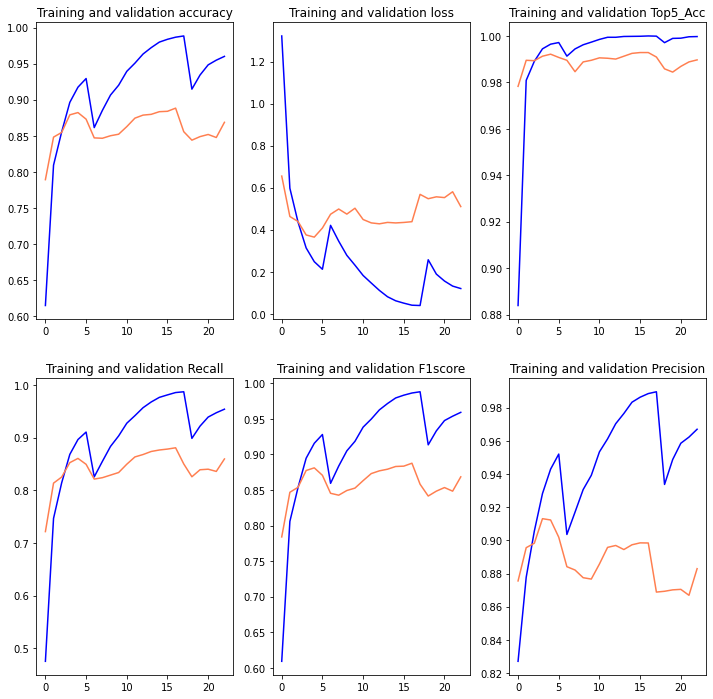

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
Top5_Acc = history.history['Top5_Acc']
val_Top5_Acc = history.history['val_Top5_Acc']
Recall = history.history['Recall']
val_Recall = history.history['val_Recall']
F1score = history.history['F1score']
val_F1score = history.history['val_F1score']
Precision = history.history['Precision']
val_Precision = history.history['val_Precision']

for iter in range(len(F1score)):
    F1score[iter] = sum(F1score[iter])/len(F1score[iter])
    val_F1score[iter] = sum(val_F1score[iter])/len(val_F1score[iter])   
    
epochs_x = range(len(acc))

fig, ax = plt.subplots(2, 3)
fig.set_figwidth(12)
fig.set_figheight(12)
ax[0][0].plot(epochs_x, acc, 'b', label='Training acc')
ax[0][0].plot(epochs_x, val_acc, label='Validation acc', color='coral')
ax[0][0].set_title('Training and validation accuracy')
ax[0][1].plot(epochs_x, loss, 'b', label='Training loss')
ax[0][1].plot(epochs_x, val_loss, label='Validation loss', color='coral')
ax[0][1].set_title('Training and validation loss')
ax[0][2].plot(epochs_x, Top5_Acc, 'b', label='Training Top5_Acc')
ax[0][2].plot(epochs_x, val_Top5_Acc, label='Validation Top5_Acc', color='coral')
ax[0][2].set_title('Training and validation Top5_Acc')
ax[1][0].plot(epochs_x, Recall, 'b', label='Training Recall')
ax[1][0].plot(epochs_x, val_Recall, label='Validation Recall', color='coral')
ax[1][0].set_title('Training and validation Recall')
ax[1][1].plot(epochs_x, F1score, 'b', label='Training F1score')
ax[1][1].plot(epochs_x, val_F1score, label='Validation F1score', color='coral')
ax[1][1].set_title('Training and validation F1score')
ax[1][2].plot(epochs_x, Precision, 'b', label='Training Precision')
ax[1][2].plot(epochs_x, val_Precision, label='Validation Precision', color='coral')
ax[1][2].set_title('Training and validation Precision')
plt.show()


In [16]:
print(acc)
print(val_acc)
print(loss)
print(val_loss)

[0.6150959730148315, 0.809424102306366, 0.8555409908294678, 0.8963786959648132, 0.917364776134491, 0.9293630123138428, 0.8614310622215271, 0.8852094411849976, 0.9065008759498596, 0.9201134443283081, 0.9393106698989868, 0.9506544470787048, 0.9633071422576904, 0.9721204042434692, 0.9797993302345276, 0.98368239402771, 0.9866055846214294, 0.9883071780204773, 0.9146596789360046, 0.934205949306488, 0.948298454284668, 0.9547992944717407, 0.9600349068641663]
[0.7893445491790771, 0.8482299447059631, 0.8547143340110779, 0.8790746331214905, 0.882229208946228, 0.8731160163879395, 0.8471783995628357, 0.846652626991272, 0.8501577377319336, 0.8522607684135437, 0.8627760410308838, 0.8745180368423462, 0.8787241578102112, 0.8797757029533386, 0.8834559917449951, 0.8839817643165588, 0.8883631229400635, 0.8557658791542053, 0.8440238237380981, 0.8489309549331665, 0.8519102931022644, 0.8477041721343994, 0.8687346577644348]
[1.3224434852600098, 0.597865879535675, 0.4368950128555298, 0.313615083694458, 0.24809

# Save Model Weights

In [17]:
os.makedirs("weights", exist_ok=True)
model.save('./weights/EfficientNetV2L_new_aug_0613_latest.h5')

# Use Trained Model for Inference



In [18]:
from tensorflow.keras.models import load_model

model = load_model("./weights/EfficientNetV2L_new_aug_0613.h5")

In [19]:
prediction = model.predict(test_generator)

219/219 [==============================] - 44s 175ms/step


In [20]:
eva_prediction = model.evaluate(ttt_generator)

219/219 [==============================] - 37s 145ms/step - loss: 0.5116 - acc: 0.8792 - Top5_Acc: 0.9866 - Recall: 0.8723 - Precision: 0.8896 - MIoU: 0.4902 - F1score: 0.8733


In [21]:
prediction_label=prediction.argmax(axis=1)
filename=test_generator.filenames[:]

for i in range(len(filename)):
    filename[i] = filename[i].split("/")[1]

outputdf=pd.DataFrame()
outputdf['Name']=filename
outputdf['Label']=prediction_label
outputdf.to_csv('prediction.csv',index=False)

In [22]:
from sklearn.metrics import classification_report

y_pred = np.array([np.argmax(x) for x in prediction])
y_test = test_generator.classes

print(type(classification_report(y_test, y_pred)))
print((classification_report(y_test, y_pred, target_names=name_list)))
print((classification_report(y_test, y_pred)))

<class 'str'>
              precision    recall  f1-score   support

         三杯雞       0.76      0.83      0.79       134
        什錦炒麵       0.93      0.89      0.91       158
         咖哩雞       0.85      0.92      0.89       153
        塔香海茸       0.98      0.96      0.97       137
         大陸妹       0.82      0.93      0.87       170
        客家小炒       0.91      0.90      0.90       153
         小番茄       1.00      0.99      0.99       171
       有機小松菜       0.42      0.50      0.45       129
       有機青松菜       0.67      0.53      0.59        99
          木瓜       0.99      1.00      1.00       162
          柳丁       0.88      0.90      0.89       143
          棗子       0.98      1.00      0.99       173
          橘子       0.91      0.90      0.90       155
        沙茶肉片       0.57      0.62      0.59       128
          油菜       0.52      0.45      0.48       146
        洋蔥炒蛋       0.92      0.94      0.93       124
          滷蛋       0.98      0.99      0.99       155
         滷雞腿 

# Confusion Matrix

In [23]:
prediction_label=prediction.argmax(axis=1)
confuse_gt=test_generator.filenames

for i in range(len(confuse_gt)):
    confuse_gt[i] = confuse_gt[i].split('/')[0]

pdpd = pd.read_excel('category_new.xlsx')
tb = pdpd['Name'].to_dict()
inv_map = {v: k for k, v in tb.items()}
confuse_gt = list(map(inv_map.get, confuse_gt))

Text(0.5, 0.98, 'Confusion matrix')

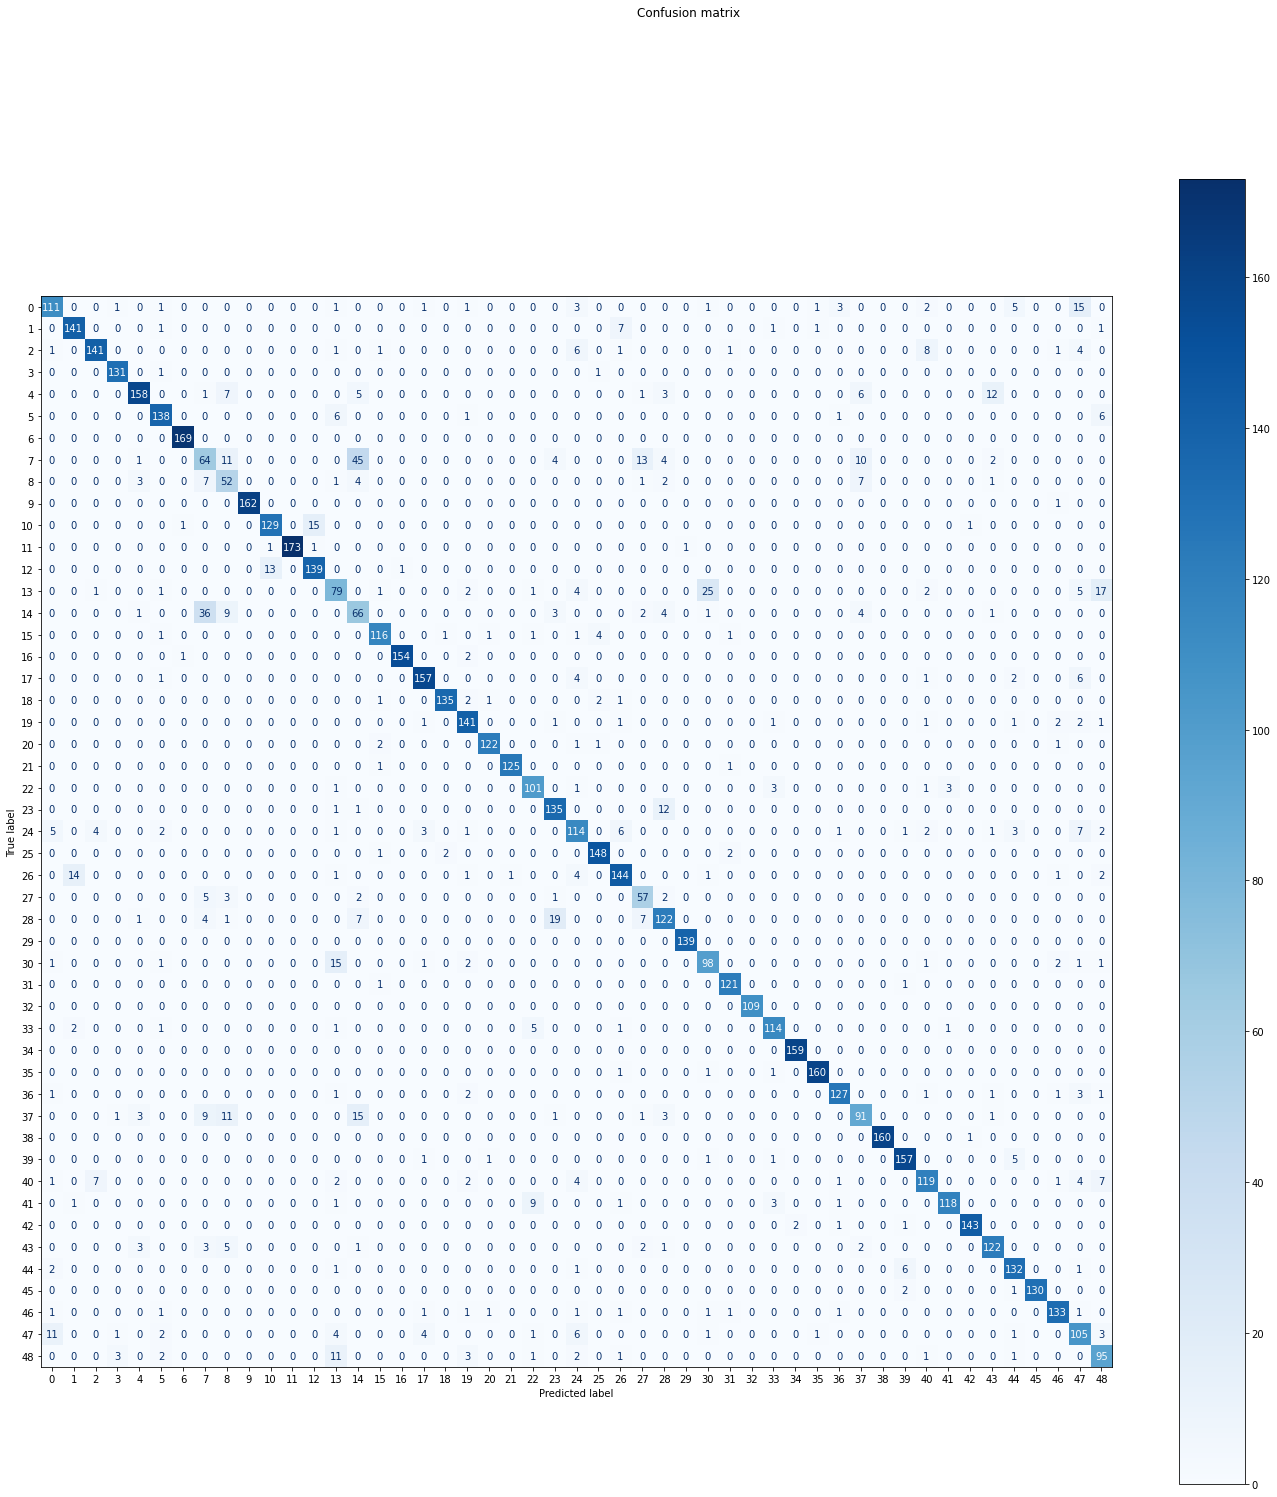

In [24]:
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
        prediction_label,
        confuse_gt,
        cmap=plt.cm.Blues
#         display_labels=name_list
    )
fig = disp.figure_
fig.set_figwidth(24)
fig.set_figheight(24)
fig.suptitle('Confusion matrix')